# Regression Modeling of NFL Salaries

### Contents
- [Imports and Functions](#a0)
- [Load Data from Pickle](#a1)
- [Define Base Features and Target](#a2)
- [Split Test and Run Baseline](#a3)
- [Clip predictions below 0](#a4)
- [Test key features](#a5)
- [Add Combinations of Stats](#a6)
- [Add Polynomial Features](#a7)
- [Regularization](#a8)  
  - [Test LASSO Regression](#a8a)  
  - [Test Ridge Regression](#a8b)  
- [Re-train and Test Final Model](#a9)
- [Average Results Across Random States](#a10)

<a id='a0'></a>
## Imports and Functions

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style("darkgrid")

In [4]:
# Defines random state for all models

rand_val = 50

In [5]:
def MAE(actuals, preds): #root mean squared error
    return np.mean(np.abs(actuals - preds))

def kfold_test(X, y, print_results = True):
    '''
    Runs model through K-Fold cross validation, returns the trained 
    model and prints the mean of each key metric across all folds.
    '''
    
    model = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state = rand_val)
    
    scores_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    scores_MAE = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    scores_MSE = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

    if print_results == True:
        print ('R2:   ', np.mean(scores_r2))
        print ('MAE:  ', np.mean(np.absolute(scores_MAE)))
        print ('RMSE: ', np.sqrt(np.mean(np.sqrt(np.absolute(scores_MSE)))))

    model.fit(X,y)

    return model

In [23]:
def residual_plots(pred, actual):
    res = actual - pred

    sns.set(font_scale=1.0)
    plt.figure(figsize=(14,12))

    # Distribution of Actual and Predicted Values
    distplt = plt.subplot(2, 2, 1)
    distplt = sns.distplot(actual,label='Actual')#,ax=axes[0])
    distplt = sns.distplot(pred,label='Predicted')#,ax=axes[0])
    distplt.legend()
    distplt.set_title("Distribution of Actual and Predicted values")
    
    # Actual vs Predicted Scatterplot 
    regplt = plt.subplot(2,2,2)
    regplt = sns.regplot(pred,actual,scatter_kws={'alpha':0.1})
    regplt.set(xlabel='Predicted',ylabel= 'Actual')
    regplt.set_title('Actual vs Predicted Values')

    # Residual Analysis 
    plt.subplot(2, 2, 3)
    plt.scatter(pred, res, alpha=.3)
    plt.title("Residual Analysis")#, fontsize = 20)
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    plt.xlim(0, .16)
    plt.plot([-1,1],[0,0], "r-")
    
    # Q-Q plot
    plt.subplot(2, 2, 4)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

<a id='a1'></a>
## Load Data from Pickle

In [2]:
with open('../pickle_data/player_df.pkl', 'rb') as picklefile: 
    player_df = pd.DataFrame(pickle.load(picklefile))

<a id='a2'></a>
## Define Base Features and Target

In [7]:
# Add column for previous year's compensation
player_df['prev_comp'] = player_df.groupby(['name'])['cap_pct'].apply(lambda grp: grp.shift(1))

# Add column identifying star players
player_df['current_star'] = player_df['prev_comp'].apply(lambda x: 1 if x > 0.12 else 0)

player_df['star_status'] = player_df.groupby(['name'])['current_star'] \
                           .transform(lambda x: x.rolling(20,min_periods=1).max())

# Drop players with no prior compensation
player_df.dropna(inplace=True)
player_df.reset_index(drop=True,inplace=True)

In [8]:
# Define base set of features and target

base_features = player_df.drop(['cap_pct','comp','name','Tm'],axis=1).copy()
base_features = pd.get_dummies(base_features)

# Define target variable
target = player_df['cap_pct'].copy()

<a id='a3'></a>
## Split Test and Run Baseline

NOTE:  Baseline was originally R2_train of 0.55 before using prev comp and star status

In [9]:
# Define base set of features and target

X_train, X_test, y_train, y_test = train_test_split(base_features, target, test_size=.2,random_state=rand_val)

In [10]:
# Train and review via KFolds

lm = kfold_test(X_train, y_train)

R2:    0.6610032681432298
MAE:   0.012525532121426814
RMSE:  0.13889380319628308


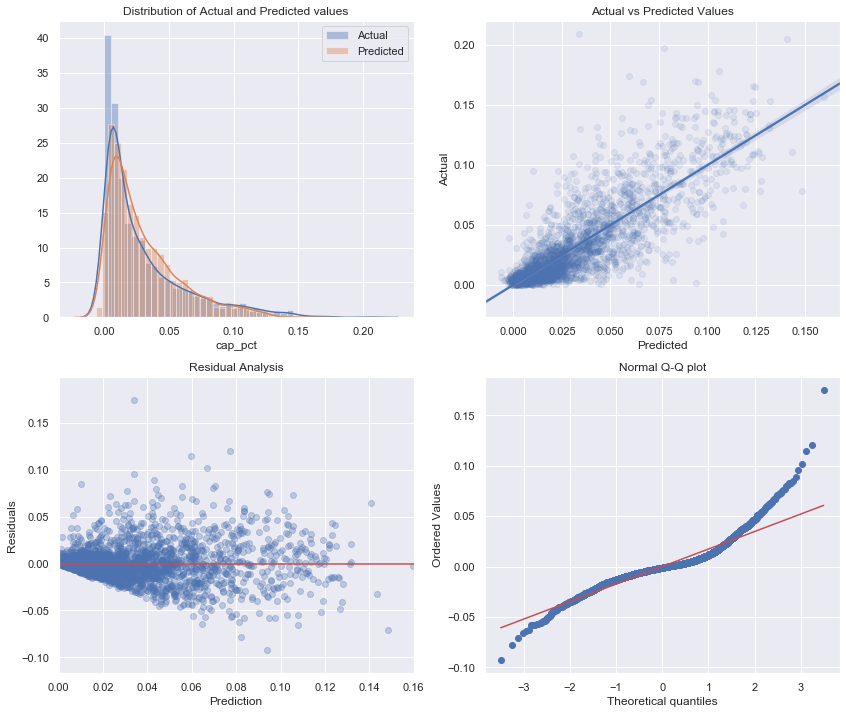

In [25]:
y_pred_train = lm.predict(X_train)

residual_plots(pred=y_pred_train, actual=y_train)

### Observations

* There are predictions of negative % salary cap, these should not go below 0
* Most of the largest preictions are wrong


<a id='a4'></a>
## Clip predictions below 0

In [26]:
def clip_predictions (pred,y,print_metrics = True):
    '''
    Clips predicted values at 0, returns the new predicted 
    values.  Prints R2 for clipped and non-clipped predictions.
    '''
    pred_clipped = np.clip(pred,0,None)
    if print_metrics == True:
        print ('R2 trained (not clipped)', r2_score(y, pred))
        print ('R2 trained (clipped)    ', r2_score(y, pred_clipped))
    return pred_clipped

y_pred_train_clipped = clip_predictions(y_pred_train,y_train)

R2 trained (not clipped) 0.6962489067922832
R2 trained (clipped)     0.6966189777765309


<a id='a5'></a>
## Test key features
Manually test individual features and sets of features

In [27]:

### Identify Features to Test ###
test_features = ['prev_comp']

test_features_set_adj = ['prev_comp','current_star',
                         'star_status','Age','GS',
                         'pos_QB','pos_RB',
                         'pass_Int_adj','pass_TD_adj',
                         'pass_Yds_adj','pass_Rate_adj',
                         'rush_TD_adj','rush_Yds_adj',
                         'rush_Y/A_adj','rec_Rec_adj',
                         'rec_TD_adj','rec_Yds_adj']

test_features_set = ['prev_comp','current_star',
                     'star_status','Age','GS',
                     'pos_QB','pos_RB',
                     'pass_Int','pass_TD',
                     'pass_Yds','pass_Rate',
                     'rush_TD','rush_Yds',
                     'rush_Y/A','rec_Rec',
                     'rec_TD','rec_Yds']

# Run r2 for each feature
feature_r2 = {}
for feature in test_features_set_adj:

    features_model_testing = base_features[[feature]].copy()
    X_train, X_test, y_train, y_test = train_test_split(features_model_testing, 
                                                        target, test_size=.2,random_state=rand_val)
    lm = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state = rand_val)
    feature_r2[feature] = np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2'))

# Display top X feature r2
top_X_values = 10
dict(sorted(feature_r2.items(), key=lambda x: x[1], reverse=True)[:top_X_values])

{'prev_comp': 0.5767321329451262,
 'GS': 0.32452218277752254,
 'pass_TD_adj': 0.2919348640100333,
 'pass_Int_adj': 0.24055983420252192,
 'pass_Yds_adj': 0.2259176854884514,
 'star_status': 0.16436139651181167,
 'pass_Rate_adj': 0.12672700605740478,
 'current_star': 0.10313727300119924,
 'pos_QB': 0.10146220210067494,
 'Age': 0.09031390664708235}

R2:    0.6634682943975534
MAE:   0.012196400528876963
RMSE:  0.13863401753578997
R2 trained (not clipped) 0.6747269989227902
R2 trained (clipped)     0.6747379716661979


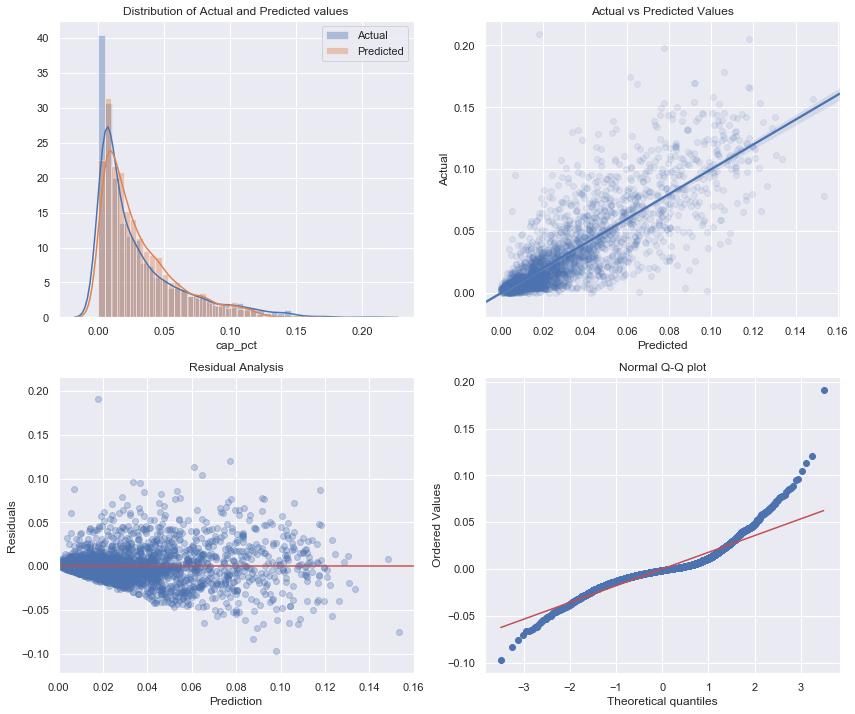

In [28]:
model_features_1 = base_features[test_features_set].copy()

X_train, X_test, y_train, y_test = train_test_split(model_features_1, target, test_size=.2,random_state=rand_val)

lm = kfold_test(X_train, y_train)

y_pred_train_clipped = clip_predictions(lm.predict(X_train),y_train)

residual_plots(pred=y_pred_train_clipped, actual=y_train)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


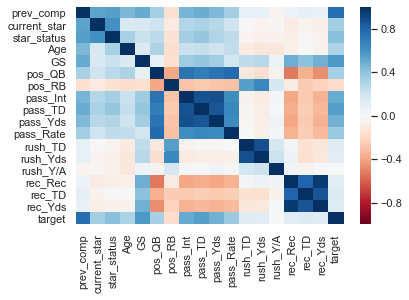

In [29]:
X_train['target'] = y_train
sns.heatmap(X_train.corr(),cmap='RdBu',vmin=-1,vmax=1);

<a id='a6'></a>
## Add Combinations of Stats

In [30]:
def feature_combo(df,org_df,qb,rb,wr):
    '''
    Creates combinations of scaled columns.  One QB column, one RB 
    column, and one WR column are added together.  Each position column is
    multiplied by the position dummy so the only values shown are relevant
    to the player's position.
    '''
    feature_combinations = [(q,r,w) for q in qb for r in rb for w in wr]
    for combination in feature_combinations:
        df['{}+{}+{}'.format(combination[0],combination[1],combination[2])] = \
        org_df['pos_QB'] * org_df[combination[0]] + \
        org_df['pos_RB'] * org_df[combination[1]] + \
        (1 - org_df['pos_QB'] - org_df['pos_RB']) * org_df[combination[2]]
    return df

In [31]:
# Identify key features to combine

qb_fields = ['pass_Yds_adj','pass_Cmp%_adj','pass_Rate_adj','pass_TD%_adj','pass_Y/A_adj','pass_Sk%_adj']
rb_fields = ['rush_Yds_adj','rush_Y/A_adj','rush_Fmb_adj']
wr_fields = ['rec_Yds_adj','rec_Ctch%_adj','rec_Y/R_adj']

In [32]:
# Create feature combinations

model_features_2 = base_features.copy()
model_features_2 = feature_combo(model_features_2,base_features,qb_fields,rb_fields,wr_fields)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(model_features_2, target, test_size=.2,random_state=rand_val)

lm = kfold_test(X_train, y_train)

y_pred_train_clipped = clip_predictions(lm.predict(X_train),y_train)

R2:    0.6610724996873392
MAE:   0.01254010427932183
RMSE:  0.13889000891447345
R2 trained (not clipped) 0.6980328575299497
R2 trained (clipped)     0.6985590287551513


In [34]:
# Run r2 for each feature
feature_r2 = {}
for feature in list(model_features_2.columns):

    features_model_testing = model_features_2[[feature]].copy()
    X_train, X_test, y_train, y_test = train_test_split(features_model_testing, 
                                                        target, test_size=.2,random_state=rand_val)
    lm = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state = rand_val)
    feature_r2[feature] = np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2'))

# Display top X feature r2
top_X_values = 20
dict(sorted(feature_r2.items(), key=lambda x: x[1], reverse=True)[:top_X_values])

{'prev_comp': 0.5767321329451262,
 'GS': 0.32452218277752254,
 'pass_Cmp': 0.30515949031510553,
 'pass_TD': 0.2996153325995251,
 'pass_Att': 0.29787986362725444,
 'pass_Cmp_adj': 0.2969657675656363,
 'pass_Att_adj': 0.29201032413903266,
 'pass_TD_adj': 0.2919348640100333,
 'pass_wins': 0.27844755823718825,
 'pass_Cmp%_adj+rush_Yds_adj+rec_Yds_adj': 0.25390995601567806,
 'pass_Yds_adj+rush_Yds_adj+rec_Yds_adj': 0.24977462704414338,
 'pass_Y/G': 0.24805093285858248,
 'pass_Rate_adj+rush_Yds_adj+rec_Yds_adj': 0.2456816726744666,
 'pass_Y/G_adj': 0.24380836509553788,
 'pass_Int_adj': 0.24055983420252192,
 'pass_Int': 0.2401612914884014,
 'pass_Yds_adj+rush_Fmb_adj+rec_Yds_adj': 0.2381544840987142,
 'pass_Yds_adj': 0.2259176854884514,
 'pass_Yds': 0.22525760966601496,
 'pass_Sk_adj': 0.22501973005296144}

Note some of the adjusted stats show promise, including "pass_CmpPct_adj+rush_Yds_adj+rec_Yds_adj" which is in the top 10 features by individual r2.

<a id='a7'></a>
## Add Polynomial Features

In [35]:
def poly_combinations(df,col):
    '''
    Adds polynomial features.  The interactions were commented out as
    they were found to cause too much overfitting.
    '''
    col_list = list(df.columns)
    feature_combinations = [(c,i) for i in col_list for c in col]
    for c in col:
        df[c+'_sqr'] = df[c] ** 2
#     for combo in feature_combinations:
#         df['{} x {}'.format(combo[0],combo[1])] = df[combo[0]] * df[combo[1]]
    return df

In [36]:
# Test which polynomial features are important

# Create testing df
poly_features = model_features_2.copy()
poly_features = poly_combinations(poly_features,list(poly_features.columns))

# Run r2 for each feature
feature_r2 = {}
for feature in list(poly_features.columns):

    features_model_testing = poly_features[[feature]].copy()
    X_train, X_test, y_train, y_test = train_test_split(features_model_testing, 
                                                        target, test_size=.2,random_state=rand_val)
    lm = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state = rand_val)
    feature_r2[feature] = np.abs(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')))
    
del(poly_features)
    
# Display top X feature r2
top_X_values = 20
dict(sorted(feature_r2.items(), key=lambda x: x[1], reverse=True)[:top_X_values])

{'prev_comp': 0.5767321329451262,
 'prev_comp_sqr': 0.43804680279500047,
 'GS_sqr': 0.33902806028294175,
 'GS': 0.32452218277752254,
 'pass_Cmp_sqr': 0.3158884271637619,
 'pass_Att_sqr': 0.3104378257534966,
 'pass_Cmp': 0.30515949031510553,
 'pass_Cmp_adj_sqr': 0.3003344440662558,
 'pass_TD': 0.2996153325995251,
 'pass_Att': 0.29787986362725444,
 'pass_Att_adj_sqr': 0.29782910029404974,
 'pass_Cmp_adj': 0.2969657675656363,
 'pass_Att_adj': 0.29201032413903266,
 'pass_TD_adj': 0.2919348640100333,
 'pass_Y/G_sqr': 0.2872228264091916,
 'pass_wins': 0.27844755823718825,
 'pass_Y/G_adj_sqr': 0.2780040517018464,
 'pass_TD_adj_sqr': 0.2547567464033375,
 'pass_TD_sqr': 0.25471398344774976,
 'pass_Cmp%_adj+rush_Yds_adj+rec_Yds_adj': 0.25390995601567806}

R2:    0.6687915263810956
MAE:   0.012316876157881502
RMSE:  0.1381210485318009
R2 trained (not clipped) 0.70734486667307
R2 trained (clipped)     0.7078527997524648


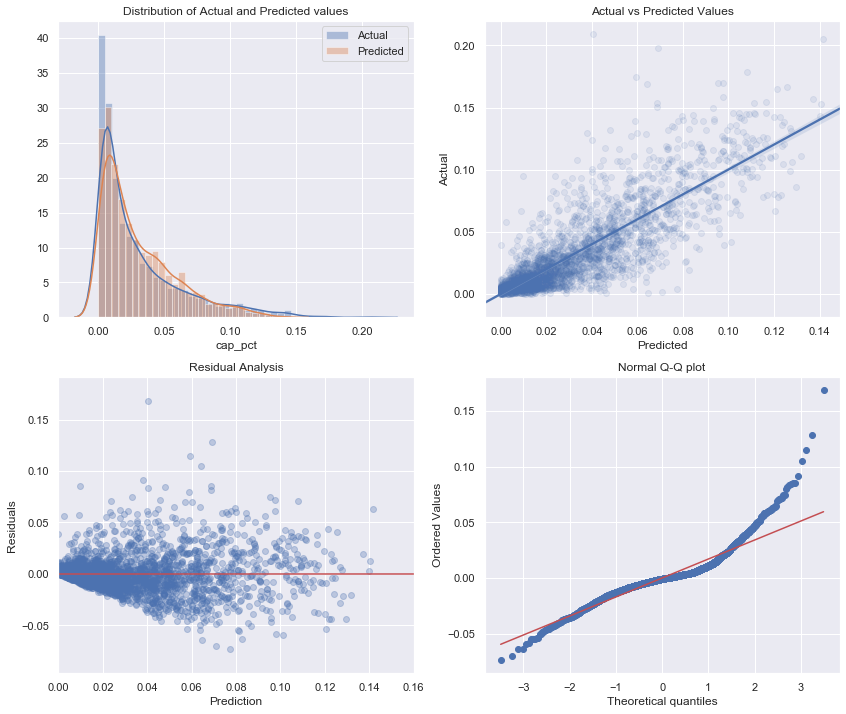

In [37]:
# Build new feature set with significant polynomial features

model_features_3 = model_features_2.copy()
model_features_3 = poly_combinations(model_features_3,['prev_comp','star_status','Age',
                                                       'GS','pass_Cmp','pass_Att','pass_Y/G'])

X_train, X_test, y_train, y_test = train_test_split(model_features_3, target, test_size=.2,random_state=rand_val)

lm = kfold_test(X_train, y_train)

y_pred_train_clipped = clip_predictions(lm.predict(X_train),y_train)

residual_plots(pred=y_pred_train_clipped, actual=y_train)

<a id='a8'></a>
## Regularization
Many features were added, regularization can help reduce variance

<a id='a8a'></a>
### Test LASSO Regression

In [38]:
X_train, X_test, y_train, y_test = train_test_split(model_features_3, target, test_size=.2,random_state=rand_val)

std = StandardScaler()

std.fit(X_train)

X_train_scaled = std.transform(X_train)

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
print (lasso_model.score(X_train_scaled, y_train))

y_pred = lasso_model.predict(X_train_scaled)
print ('ideal alpha: ',lasso_model.alpha_)

0.5256461223844564
ideal alpha:  0.01


R2 trained (not clipped) 0.5256461223844564
R2 trained (clipped)     0.5256461223844564


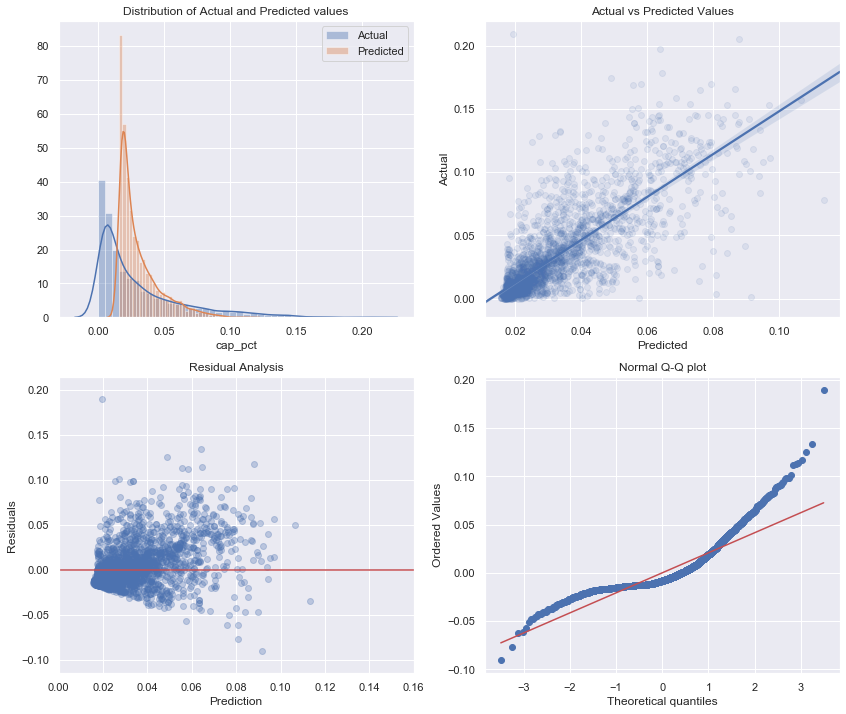

In [39]:
y_pred_train_clipped = clip_predictions(y_pred,y_train)

residual_plots(pred=y_pred_train_clipped, actual=y_train)

In [43]:
# Important features

lasso_features = pd.DataFrame(list(zip(model_features_3.columns,lasso_model.coef_)),columns=['feature','coef'])
lasso_features['abs_coef'] = abs(lasso_features['coef'])
lasso_features.sort_values('abs_coef',ascending=False).head(10)

,feature,coef,abs_coef
83,prev_comp,0.013965,0.013965
146,GS_sqr,0.002038,0.002038
147,pass_Cmp_sqr,0.000979,0.000979
103,pass_Cmp%_adj+rush_Y/A_adj+rec_Y/R_adj,0.000000,0.000000
96,pass_Yds_adj+rush_Fmb_adj+rec_Ctch%_adj,0.000000,0.000000
97,pass_Yds_adj+rush_Fmb_adj+rec_Y/R_adj,0.000000,0.000000
98,pass_Cmp%_adj+rush_Yds_adj+rec_Yds_adj,0.000000,0.000000
99,pass_Cmp%_adj+rush_Yds_adj+rec_Ctch%_adj,0.000000,0.000000
100,pass_Cmp%_adj+rush_Yds_adj+rec_Y/R_adj,0.000000,0.000000
101,pass_Cmp%_adj+rush_Y/A_adj+rec_Yds_adj,0.000000,0.000000


<a id='a8b'></a>
### Test Ridge Regression

In [44]:
X_train, X_test, y_train, y_test = train_test_split(model_features_3, target, test_size=.2,random_state=rand_val)

std = StandardScaler()

std.fit(X_train)

X_train_scaled = std.transform(X_train)

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train_scaled, y_train)
print (ridge_model.score(X_train_scaled, y_train))

y_pred = ridge_model.predict(X_train_scaled)
print ('ideal alpha: ',ridge_model.alpha_)

0.7036942591793776
ideal alpha:  12.458833642950081


R2 trained (not clipped) 0.7036942591793776
R2 trained (clipped)     0.7039555997341929


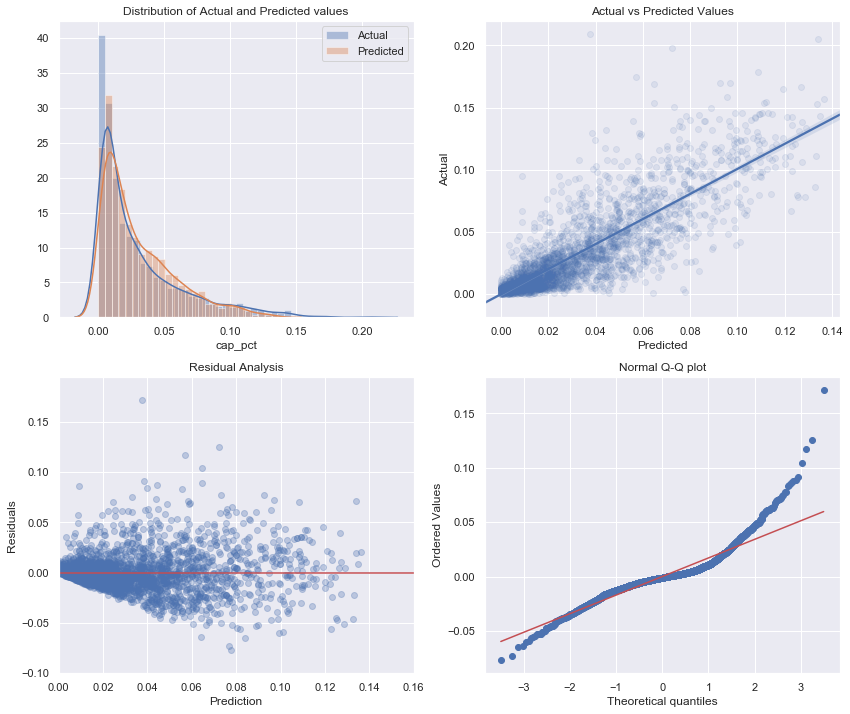

In [45]:
y_pred_train_clipped = clip_predictions(y_pred,y_train)

residual_plots(pred=y_pred_train_clipped, actual=y_train)

In [46]:
# Important features

ridge_features = pd.DataFrame(list(zip(model_features_2.columns,ridge_model.coef_)),columns=['feature','coef'])
ridge_features['abs_coef'] = abs(ridge_features['coef'])
ridge_features.sort_values('abs_coef',ascending=False).head(10)

,feature,coef,abs_coef
83,prev_comp,0.025113,0.025113
30,pass_GWD_adj,0.007228,0.007228
1,Age,0.007055,0.007055
76,rec_Tgt_adj,0.006271,0.006271
10,pass_GWD,-0.006060,0.006060
40,pass_NY/A_adj,-0.005394,0.005394
77,rec_Yds_adj,-0.005108,0.005108
68,rec_Y/G,0.004800,0.004800
3,GS,-0.004542,0.004542
44,pass_Y/C_adj,0.004522,0.004522


Ridge Regression performs better than LASSO Regression, will move forward with Ridge Regression model.

<a id='a9'></a>
## Re-train and Test Final Model

In [65]:
def final_model(X, y, rv):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=rv)

    # Scale Features
    std = StandardScaler()
    std.fit(X_train)
    X_train_scaled = std.transform(X_train)
    X_test_scaled = std.transform(X_test)

    # Train model
    alphavec = 10**np.linspace(-2,2,200)
    final_model = RidgeCV(alphas = alphavec, cv=5)
    final_model.fit(X_train_scaled, y_train)

    # Generate Predictions with final model
    y_test_pred = final_model.predict(X_test_scaled)
    
    return clip_predictions(y_test_pred,y_test,print_metrics=False), y_test

def display_results(R2,MAE,RMSE):
    
    # Salary cap 2019
    salary_cap_2019 = 188200000
    
    # Print metrics for final model
    print ('R2 Out of Sample:       ', np.mean(np.asarray(R2)))
    print ('----------------------------------------')
    print ('MAE Out of Sample:      ', np.mean(np.asarray(MAE)))
    print ('MAE Out of Sample ($):  ', np.mean(np.asarray(MAE)) * salary_cap_2019) 
    print ('----------------------------------------')
    print ('RMSE Out of Sample:     ', np.mean(np.asarray(RMSE)))
    print ('RMSE Out of Sample ($): ', np.mean(np.asarray(RMSE))* salary_cap_2019)

In [66]:
# Run final model
y_test_pred_clipped, y_test = final_model(X = model_features_3, y = target, rv = rand_val)

# Calculate metrics
r2 = r2_score(y_test,y_test_pred_clipped)
mae = mean_absolute_error(y_test,y_test_pred_clipped)
rmse = np.sqrt(mean_squared_error(y_test,y_test_pred_clipped))

# Display metrics
display_results(r2,mae,rmse)

R2 Out of Sample:        0.6901238107473713
----------------------------------------
MAE Out of Sample:       0.01141487707387579
MAE Out of Sample ($):   2148279.8653034237
----------------------------------------
RMSE Out of Sample:      0.018426868402711898
RMSE Out of Sample ($):  3467936.633390379


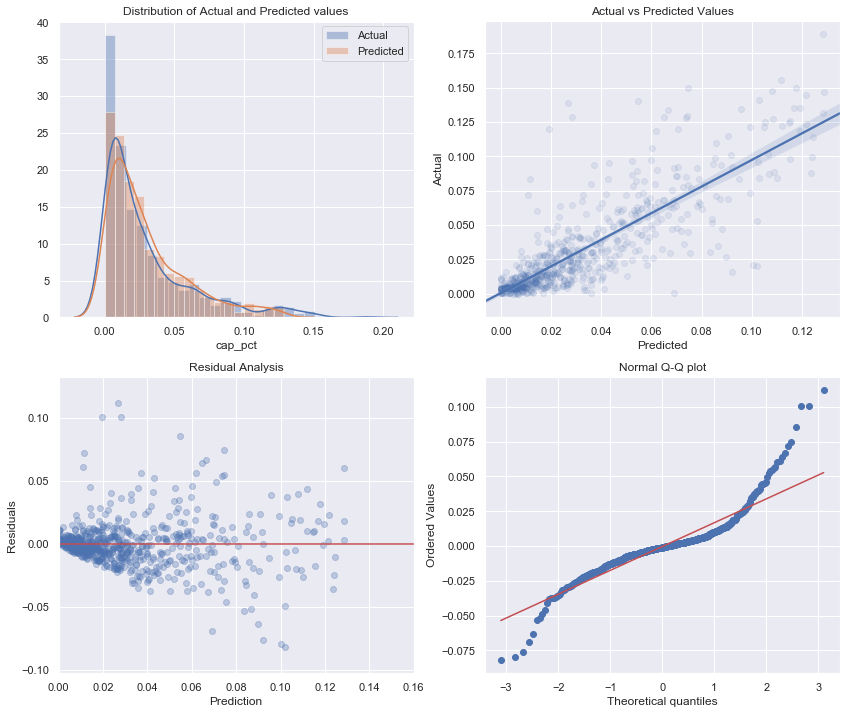

In [60]:
residual_plots(pred=y_test_pred_clipped, actual=y_test)

<a id='a10'></a>
## Average Results Across Random States

In [67]:
R2_list = []
MAE_list = []
RMSE_list = []

for r_state in range(101):
    # Run final model
    y_test_pred_clipped, y_test = final_model(X = model_features_3, y = target, rv = r_state)

    # Print metrics for final model
    R2_list.append(r2_score(y_test,y_test_pred_clipped))
    MAE_list.append(mean_absolute_error(y_test,y_test_pred_clipped))
    RMSE_list.append(np.sqrt(mean_squared_error(y_test,y_test_pred_clipped)))

    
display_results(R2_list,MAE_list,RMSE_list)

R2 Out of Sample:        0.6810903290126109
----------------------------------------
MAE Out of Sample:       0.011908634899416673
MAE Out of Sample ($):   2241205.088070218
----------------------------------------
RMSE Out of Sample:      0.01869566257136828
RMSE Out of Sample ($):  3518523.6959315105
